In [1]:
import numpy as np
import matplotlib.pyplot as plt

#MNIST dataset
import torch
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet, GSDRUNet, GSPnP
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP, RED
from deepinv.utils.parameters import get_GSPnP_params
from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# MNIST digits dataset

In [106]:
transform = transforms.Compose([transforms.ToTensor()])
noise = 0.1
train_dataset = datasets.MNIST(root=".", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=".", train=False, transform=transform, download=True)

radon = dinv.physics.Tomography(
    angles=28,
    img_width=28,
    noise_model=dinv.physics.noise.GaussianNoise(sigma = noise),
    device=device,
)



In [88]:
"""
deepinv_datasets_path = dinv.datasets.generate_dataset(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    physics=physics,
    device=device,
    save_dir="MNIST",
    train_datapoints=100,
    test_datapoints=10,
)
train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

"""
train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

## Parameters and priors 
 - stepsize, lambda, noise level, iterations and priors defined

In [118]:
params = {"stepsize": 0.01, "lambda": 1, "g_param": noise}
max_iter = 500
channels = 1 #3 for RGB, 1 for greyscale
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()



In [108]:
from deepinv.models.GSPnP import GSPnP
priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)




## Gradient-Step PnP setup

In [72]:
import torch.nn as nn
class StudentGrad(nn.Module):
    def __init__(self, denoiser):
        super().__init__()
        self.model = denoiser

    def forward(self, x, sigma):
        return self.model(x, sigma)


class GSPnP(nn.Module):
    r"""
    Gradient Step module to use a denoiser architecture as a Gradient Step Denoiser.
    See https://arxiv.org/pdf/2110.03220.pdf.
    Code from https://github.com/samuro95/GSPnP.

    :param nn.Module denoiser: Denoiser model.
    :param float alpha: Relaxation parameter
    """

    def __init__(self, denoiser, alpha=1.0):
        super().__init__()
        self.student_grad = StudentGrad(denoiser)
        self.alpha = alpha
        self.explicit_prior = False

    def potential(self, x, sigma, *args, **kwargs):
        N = self.student_grad(x, sigma)
        return (
            0.5
            * self.alpha
            * torch.norm((x - N).view(x.shape[0], -1), p=2, dim=-1) ** 2
        )

    def potential_grad(self, x, sigma, *args, **kwargs):
        r"""
        Calculate :math:`\nabla g` the gradient of the regularizer :math:`g` at input :math:`x`.

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level :math:`\sigma` (std)
        """
        with torch.enable_grad():
            x = x.float()
            x = x.requires_grad_()
            N = self.student_grad(x, sigma)
            JN = torch.autograd.grad(
                N, x, grad_outputs=x - N, create_graph=True, only_inputs=True
            )[0]
        Dg = x - N - JN
        return self.alpha * Dg

    def forward(self, x, sigma):
        r"""
        Denoising with Gradient Step Denoiser

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level (std)
        """
        Dg = self.potential_grad(x, sigma)
        x_hat = x - Dg
        return x_hat


In [109]:
denoiser = DRUNet(
        in_channels=channels,
        out_channels= channels,
        pretrained= 'download',
        device= 'cpu',
    )

GSmodel = GSPnP(denoiser, alpha = 1)

gsdrunet =GSDRUNet(
    in_channels= 3,
    out_channels= 3,
    pretrained="download",
    device="cpu",
)

#gsprior = GSPnP(denoiser = gsdrunet)



In [93]:
modelGSPnP = optim_builder(
    iteration="PGD",
    prior= GSmodel,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)
modelGSPnP.eval()

AttributeError: 'GSPnP' object has no attribute 'explicit_prior'

# PnP-PGD/FBS

In [122]:
model1 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [227]:
class GSPnP(RED):
    r"""
    Gradient-Step Denoiser prior.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def g(self, x, *args, **kwargs):
        r"""
        Computes the prior :math:`g(x)`.

        :param torch.tensor x: Variable :math:`x` at which the prior is computed.
        :return: (torch.tensor) prior :math:`g(x)`.
        """
        return self.denoiser.potential(x, *args, **kwargs)





gsdrunet =GSDRUNet(
    in_channels= 3,
    out_channels= 3,
    pretrained="download",
    device="cpu",
)

gsprior = GSPnP(denoiser = gsdrunet)

In [95]:
mnist = MNIST(root='./data', train=True, download=True, transform=transform)
digit, label = mnist[0]
 
c = torch.stack([digit] * 3, dim=0)

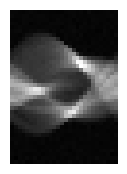

In [111]:
y = radon(digit.reshape(1, 1, 28, 28))
fbp = radon.A_dagger(y)
plot(y)

In [ ]:
#GS-PnP
x_modelgs, metricsgs = modelGSPnP(y, radon, x_gt = c, compute_metrics = True)

In [112]:
x_model1, metrics1 = model1(y, radon, x_gt = digit, compute_metrics = True)
x_model2, metrics2 = model2(y, radon, x_gt = digit, compute_metrics = True)
x_model3, metrics3 = model3(y, radon, x_gt = digit, compute_metrics = True)


Iteration 403, current converge crit. = 9.71E-06, objective = 1.00E-05 
Iteration 486, current converge crit. = 9.94E-06, objective = 1.00E-05 


In [123]:
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = digit, compute_metrics = True)

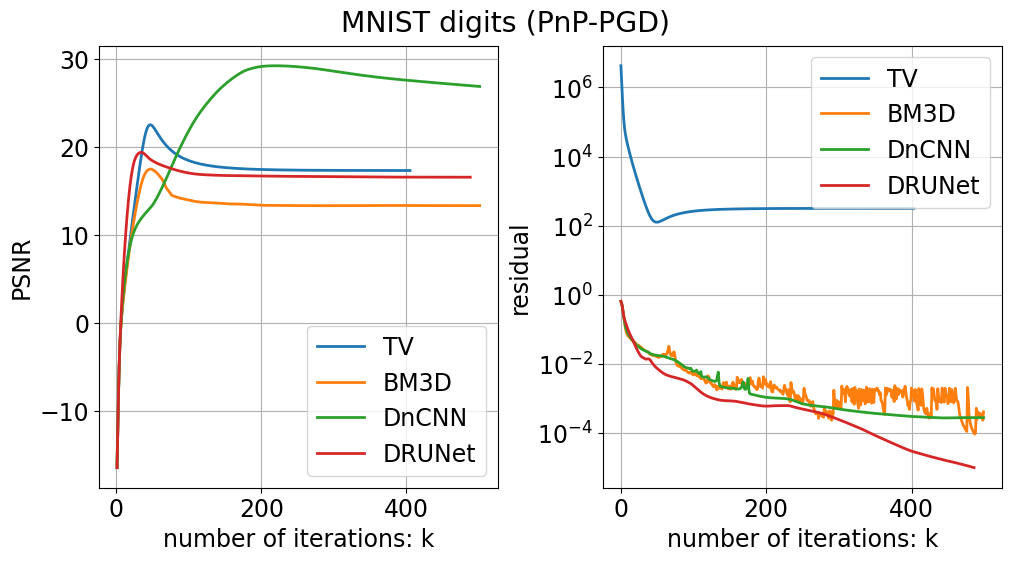

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('MNIST digits (PnP-PGD)')
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)

    return round(psnrs[-1], 2)


tvpsnr = plot_psnrs_residuals(metrics1, 'TV')
bm3dpsnr = plot_psnrs_residuals(metricsbm3d, 'BM3D')
dncnnpsnr = plot_psnrs_residuals(metrics2, 'DnCNN')
drunetpsnr =plot_psnrs_residuals(metrics3, 'DRUNet')

psnrs_list = [tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr]

ax1.legend()
ax2.legend()

## Plotting functions for the different estimates

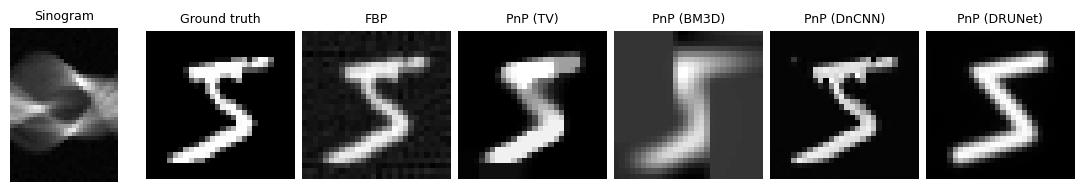

In [127]:
imgs = [y, digit, fbp, x_model1, x_modelbm3d, x_model2, x_model3]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)"])

In [128]:
def PSNR(original, img, max_value = 1): 
    mse = np.mean((np.array(original, dtype=np.float32) - np.array(img, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    psnr = 20 * np.log10(max_value / (np.sqrt(mse)))
    return psnr

fbp_psnr = PSNR(digit, fbp)
fbp_psnr

23.798882860436667

In [102]:
def plt_ready(ground_truth, y, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, imsize):
    sinogram = y.view(40,28)
    gt = ground_truth.view(imsize)
    fbp = FBP.view(imsize)
    tv_x = x_tv.view(imsize)
    bm3d_x = x_bm3d.view(imsize)
    dncnn_x = x_dncnn.view(imsize)
    drunet_x = x_drunet.view(imsize)

    return sinogram, gt, fbp, tv_x, bm3d_x, dncnn_x, drunet_x

def plotting_estimates(gt, fbp, x1, x2, x3, x4, psnrs_list):
    size = 15
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    axs[0, 0].set_title("Ground Truth", fontsize = size)
    axs[0, 0].imshow(gt, cmap='gray')
    axs[0, 1].set_title("FBP", fontsize = size)
    axs[0, 1].imshow(fbp, cmap='gray')
    axs[0, 2].set_title(f'TV \n PSNR: {psnrs_list[0]:.2f} dB', fontsize = size)
    axs[0, 2].imshow(x1, cmap='gray')
    axs[1, 0].set_title(f'BM3D \n PSNR: {psnrs_list[1]:.2f} dB', fontsize = size)
    axs[1, 0].imshow(x2, cmap='gray')
    axs[1, 1].set_title(f'PnP-DnCNN \n PSNR: {psnrs_list[2]:.2f} dB', fontsize = size)
    axs[1, 1].imshow(x3, cmap='gray')
    axs[1, 2].set_title(f'PnP-DRUNet \n PSNR: {psnrs_list[3]:.2f} dB', fontsize = size)
    axs[1, 2].imshow(x4, cmap='gray')

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')


imsize = (28, 28)

<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\as5057\AppData\Local\Temp\ipykernel_25140\1289958391.py:5: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("Projection angle ($\Theta$)")


Text(0.5, 0, 'Projection angle ($\\Theta$)')

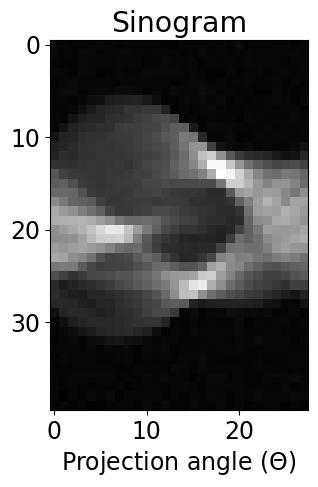

In [129]:
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(digit, y, fbp, x_model1, x_modelbm3d, x_model2, x_model3, imsize)

plt.imshow(sinogram, cmap = 'gray')
plt.title("Sinogram")
plt.xlabel("Projection angle ($\Theta$)")



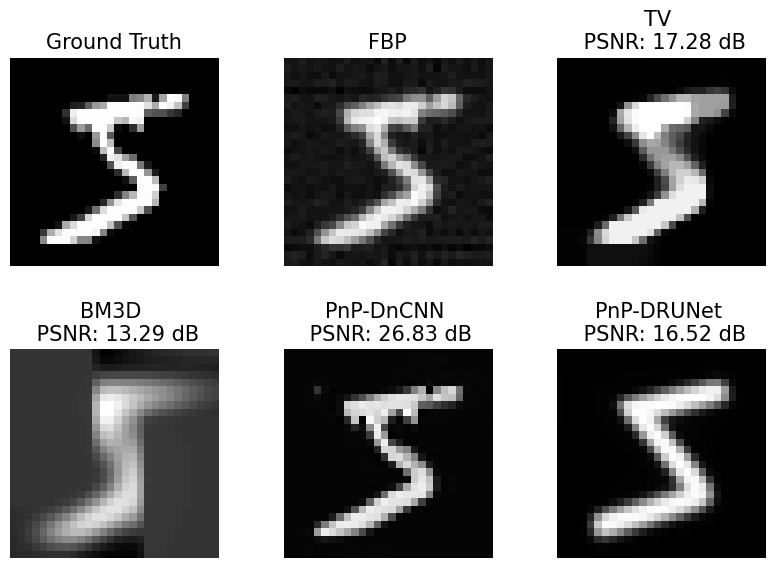

In [130]:
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, psnrs_list)


# PnP-ADMM setup with the same priors

In [131]:
params = {"stepsize": 0.01, "lambda": 1, "beta": 1, "g_param": noise}
ADMM1 = optim_builder(
    iteration="ADMM",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
ADMM2 = optim_builder(
    iteration="ADMM",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
ADMM3 = optim_builder(
    iteration="ADMM",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

ADMMbm3d = optim_builder(
    iteration="ADMM",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [132]:
admm_model1, metrics_admm_1 = ADMM1(y, radon, x_gt = digit, compute_metrics = True)
admm_model2, metrics_admm_2 = ADMM2(y, radon, x_gt = digit, compute_metrics = True)
admm_model3, metrics_admm_3 = ADMM3(y, radon, x_gt = digit, compute_metrics = True)
admm_modelbm3d, metrics_admm_bm3d = ADMMbm3d(y, radon, x_gt = digit, compute_metrics = True)

Iteration 408, current converge crit. = 9.96E-06, objective = 1.00E-05 
Iteration 497, current converge crit. = 9.89E-06, objective = 1.00E-05 


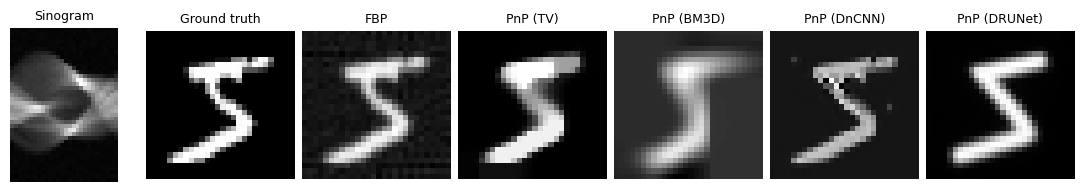

In [133]:
imgs = [y, digit, fbp, admm_model1, admm_modelbm3d, admm_model2, admm_model3]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)"])

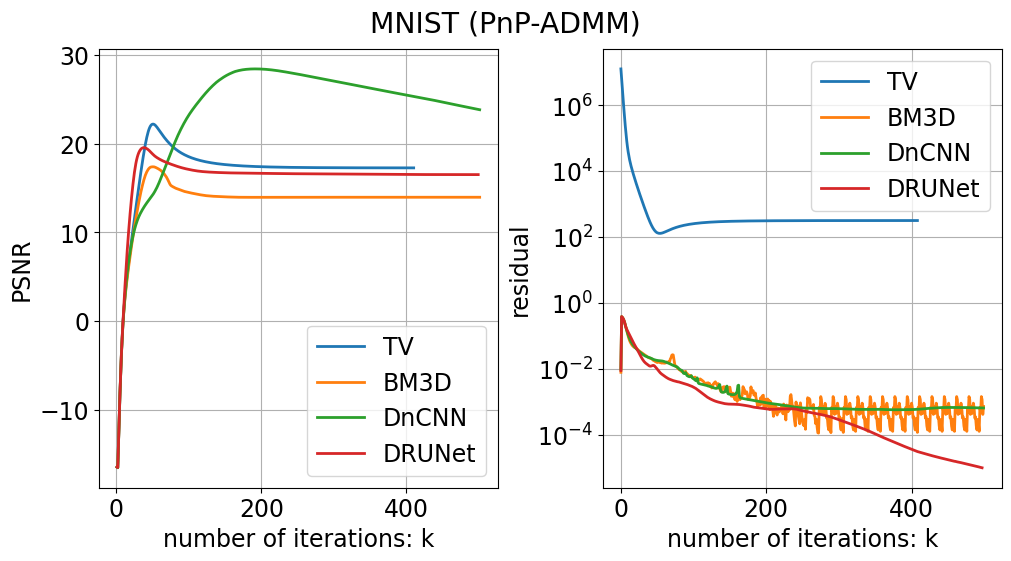

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle("MNIST (PnP-ADMM)")
tvpsnr = plot_psnrs_residuals(metrics_admm_1, 'TV')
bm3dpsnr = plot_psnrs_residuals(metrics_admm_bm3d, 'BM3D')
dncnnpsnr = plot_psnrs_residuals(metrics_admm_2, 'DnCNN')
drunetpsnr =plot_psnrs_residuals(metrics_admm_3, 'DRUNet')

psnrs_list = [tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr]

ax1.legend()
ax2.legend()

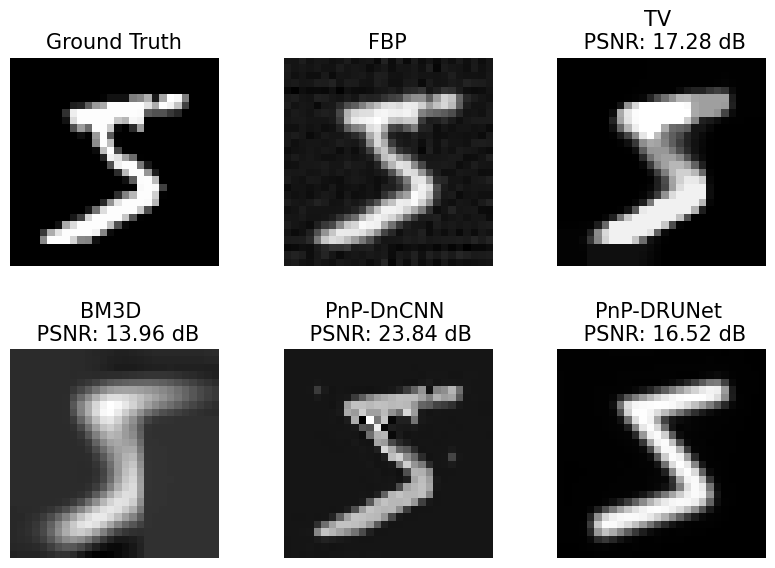

In [139]:
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(digit, y, fbp, admm_model1, admm_modelbm3d, admm_model2, admm_model3, imsize)
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, psnrs_list)